# Hand Gesture Recognition — ML Pipeline

This notebook builds a machine learning pipeline to classify **18 hand gestures** using 3D hand landmark coordinates extracted from images/video.

## Pipeline Overview

1. **Data Loading** — Load the hand landmark dataset  
2. **Feature Engineering** — Column inspection  
3. **Preprocessing** — Translation & scale normalization  
4. **Label Encoding** — Convert gesture names to numeric labels  
5. **Train/Test Split** — 80/20 stratified split  
6. **SVM Hyperparameter Tuning** — GridSearchCV with 5-fold cross-validation  
7. **Model Training & Evaluation** — Random Forest, SVM, KNN comparison  
8. **Visualization** — Performance chart & confusion matrix  
9. **Model Persistence** — Save best model with joblib  
10. **Real-Time Inference** — Live webcam gesture recognition via MediaPipe  


## 1. Imports

Import all required libraries:
- **pandas / numpy** — data manipulation and numerical operations  
- **matplotlib / seaborn** — visualization  
- **scikit-learn** — classifiers, metrics, preprocessing, and model selection  
- **joblib** — model serialization  


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlflow_utils import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import joblib

In [30]:
# =========================
# MLflow Experiment Setup
# =========================

mlflow.set_tracking_uri("http://127.0.0.1:5000")
set_experiment("HandGesture_Classification_Experiment")


2026/02/28 23:16:07 INFO mlflow.tracking.fluent: Experiment with name 'HandGesture_Classification_Experiment' does not exist. Creating a new experiment.


## 2. Load Dataset

Load the hand landmark CSV file.

The dataset contains **25,675 samples** across **64 columns**:
- 63 feature columns representing the **(x, y, z)** coordinates of **21 hand landmarks** (landmark 1–21)
- 1 target column: **`label`** (gesture name)

Each row is a single hand pose frame.


In [31]:
df = pd.read_csv('/Users/ahmedtarek/Developer/Python/ML1 Project/hand_landmarks_data.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (25675, 64)


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


## 3. Inspect Feature Columns

Print all column names to verify the structure:
- Columns `x1`–`z21` → 21 landmarks × 3 axes = **63 features**
- Column `label` → target class


In [32]:
print(df.columns)

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7', 'y7', 'z7', 'x8', 'y8', 'z8',
       'x9', 'y9', 'z9', 'x10', 'y10', 'z10', 'x11', 'y11', 'z11', 'x12',
       'y12', 'z12', 'x13', 'y13', 'z13', 'x14', 'y14', 'z14', 'x15', 'y15',
       'z15', 'x16', 'y16', 'z16', 'x17', 'y17', 'z17', 'x18', 'y18', 'z18',
       'x19', 'y19', 'z19', 'x20', 'y20', 'z20', 'x21', 'y21', 'z21', 'label'],
      dtype='object')


## 4. Data Visualization — Hand Landmark Skeletons

Before training, we visualize the **raw hand landmark data** to confirm that MediaPipe has captured meaningful skeletal structure for each gesture class.

### What we plot
| Plot | Description |
|------|-------------|
| **One skeleton per class** | 18-panel grid — one representative sample per gesture, drawn as a connected skeleton |
| **Intra-class overlay** | 30 samples overlaid per class — shows how consistent each gesture is across different hands |
| **Annotated skeleton** | Single gesture with all 21 landmark indices labelled — useful for understanding the feature space |

### Landmark anatomy
MediaPipe outputs **21 landmarks** per hand, numbered 0–20:

- **0** — Wrist (origin after normalization)
- **1–4** — Thumb (CMC → Tip)
- **5–8** — Index finger (MCP → Tip)
- **9–12** — Middle finger (MCP → Tip)
- **13–16** — Ring finger (MCP → Tip)
- **17–20** — Pinky (MCP → Tip)

> **Note:** Plots are shown on the **normalized** landmarks (wrist recentred, scale divided by mean fingertip distance) — the same representation the models will train on.

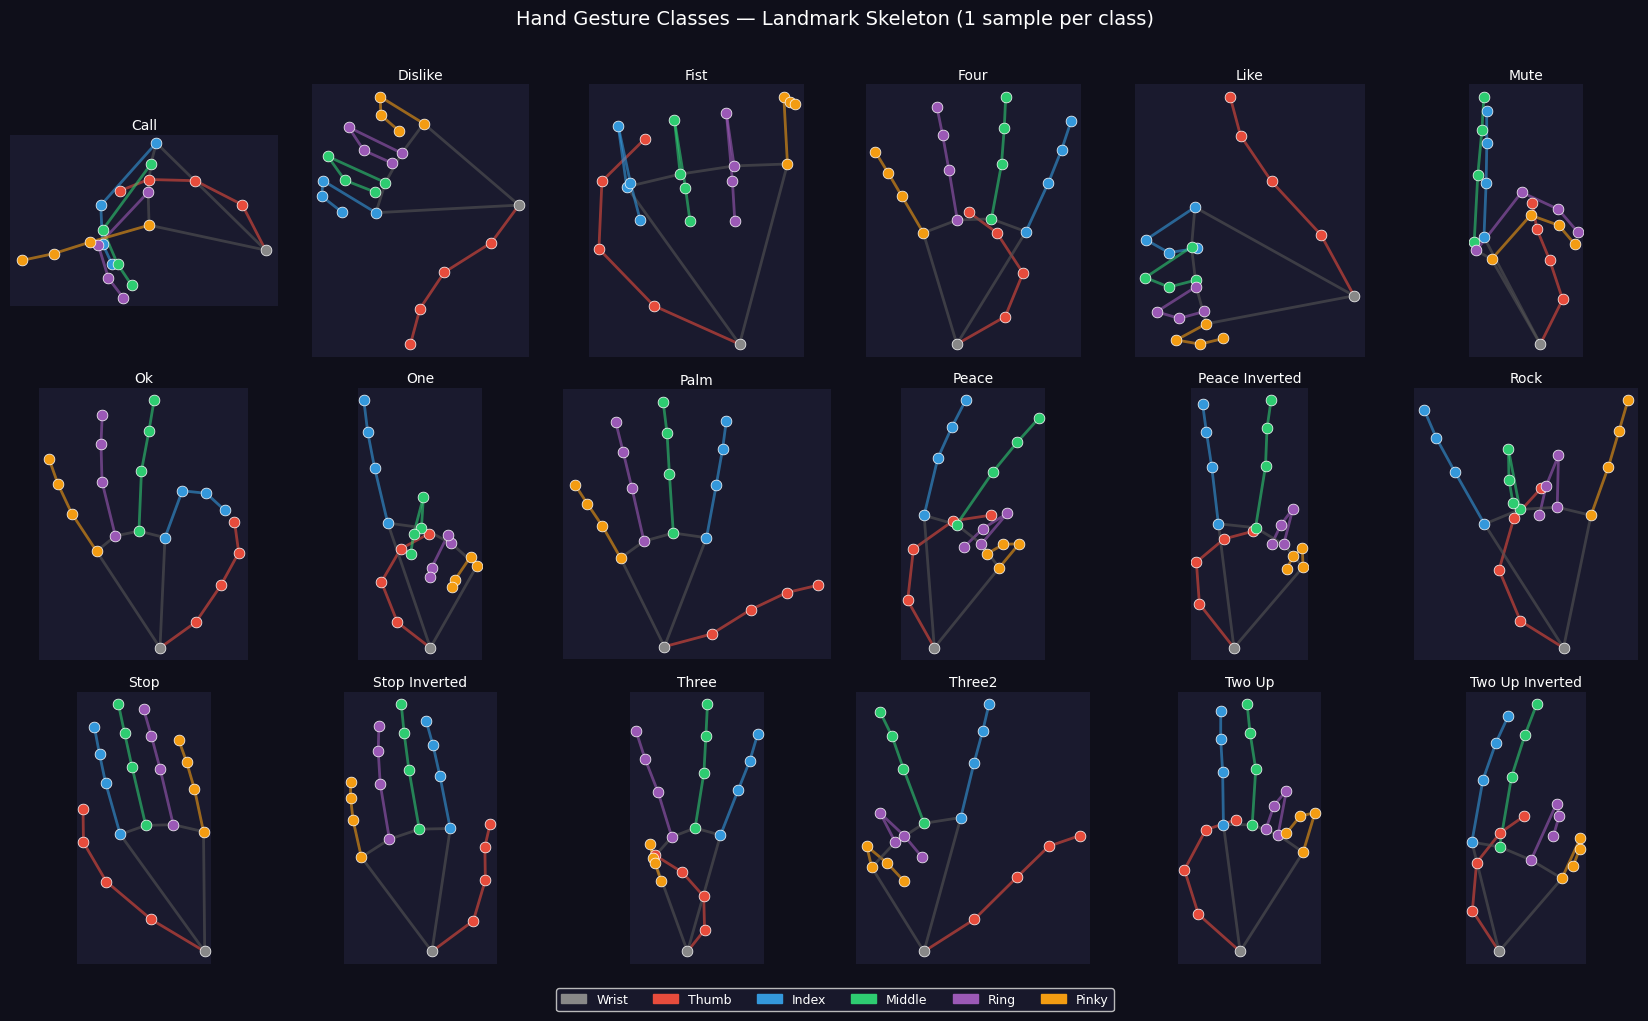

✓ Plotted 18 gesture classes.


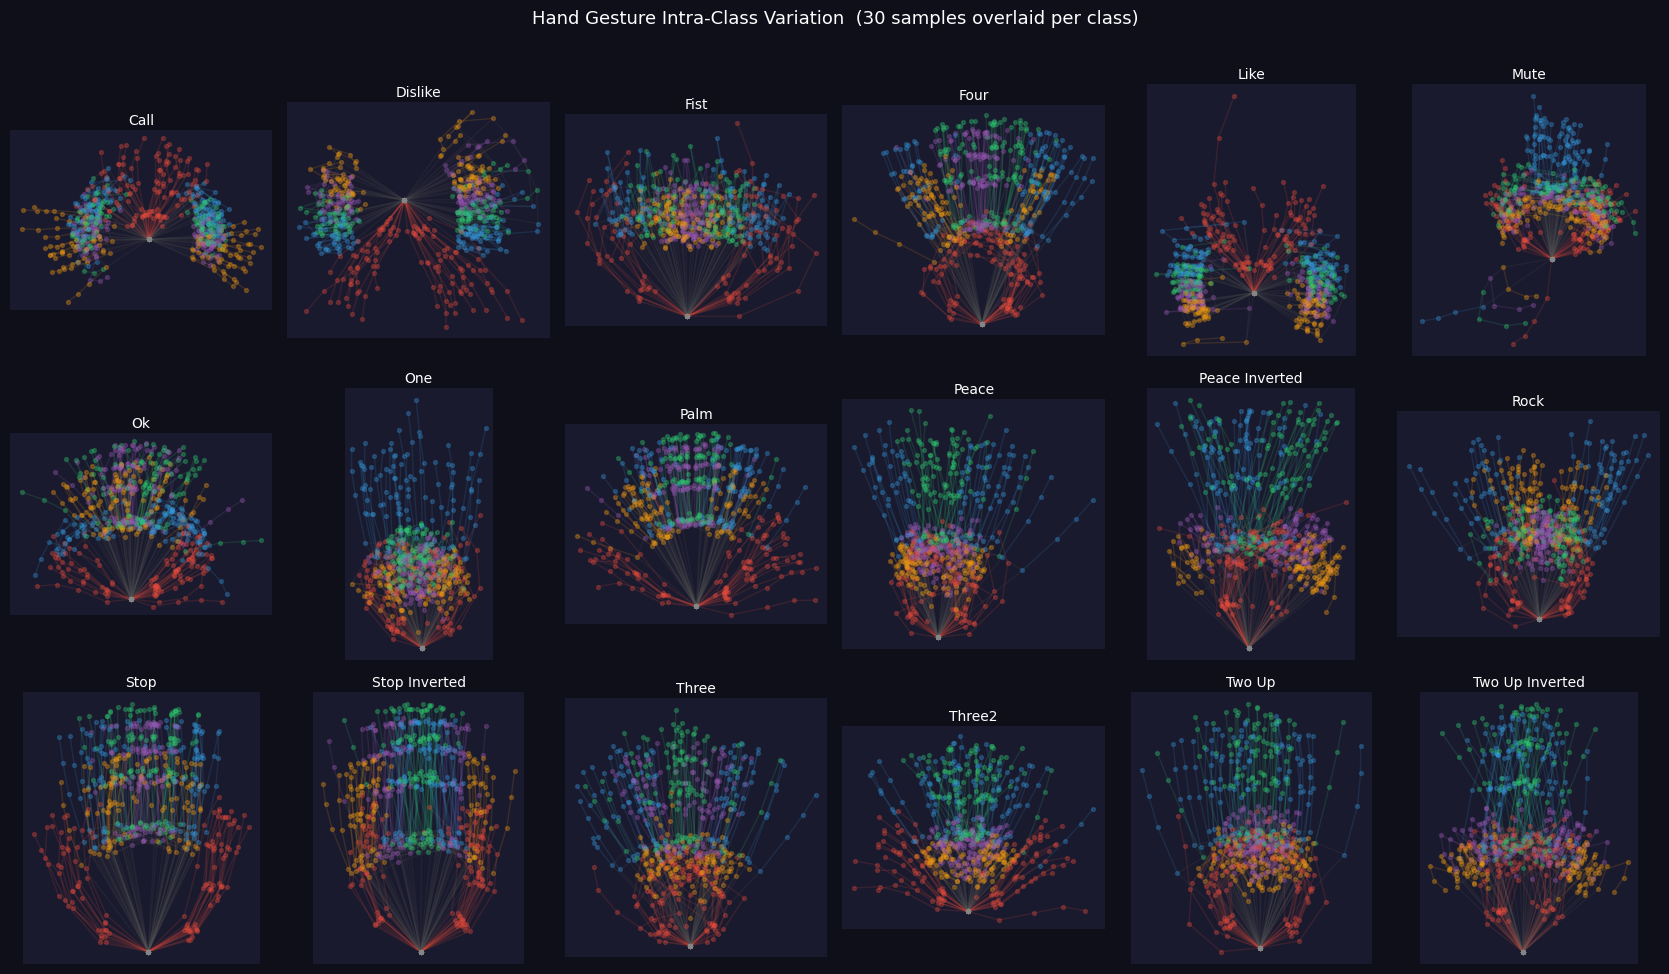

✓ Overlaid 30 samples for each of 18 classes.


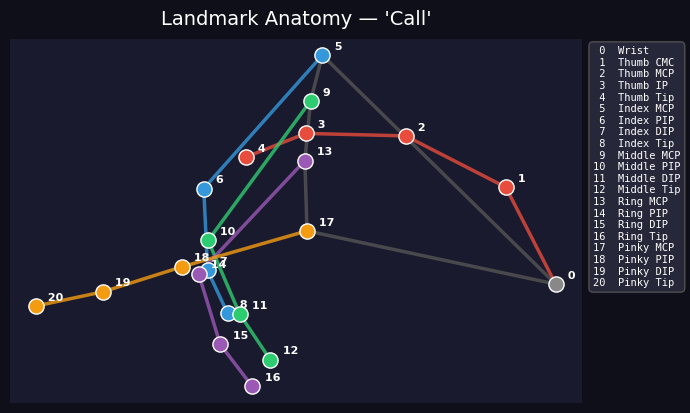

✓ Annotated skeleton for gesture: 'call'


In [33]:
from hand_landmark_visualization import plot_one_sample_per_class, plot_overlay_per_class, plot_annotated_sample
plot_one_sample_per_class(df, normalized=True)
plot_overlay_per_class(df, n_samples=30, normalized=True)
plot_annotated_sample(df, gesture_name="call", normalized=True)

## 5. Feature Normalization (Preprocessing)

Apply two normalization steps to make features **position- and scale-invariant**:

### Step 1 — Translation Normalization
Subtract the wrist landmark (landmark 0) coordinates from all X and Y values.  
This centers the hand at the origin, removing camera/position bias.

### Step 2 — Scale Normalization  
Compute the mean Euclidean distance from the wrist to the **4 fingertips** (indices 8, 12, 16, 20 — excluding the thumb).  
Divide all X and Y coordinates by this scale factor so that hand size differences don't affect classification.

> ⚠️ Z coordinates are **not** scaled.


In [34]:
X = df.drop('label', axis=1).copy()
y = df['label']

x_cols = list(range(0, X.shape[1], 3))
y_cols = [c + 1 for c in x_cols]
z_cols = [c + 2 for c in x_cols]

# 1️⃣ Translation normalization (X and Y only)
X.iloc[:, x_cols] = X.iloc[:, x_cols].sub(X.iloc[:, 0], axis=0)
X.iloc[:, y_cols] = X.iloc[:, y_cols].sub(X.iloc[:, 1], axis=0)

# 2️⃣ Scale normalization using 4 fingertips (no thumb)
fingertip_indices = [8, 12, 16, 20]

fingertip_distances = []
for tip in fingertip_indices:
    col_x = tip * 3
    col_y = tip * 3 + 1
    dist = np.sqrt(X.iloc[:, col_x]**2 + X.iloc[:, col_y]**2)
    fingertip_distances.append(dist)

div = np.mean(fingertip_distances, axis=0)
div = np.where(div < 1e-6, 1e-6, div)

X.iloc[:, x_cols] = X.iloc[:, x_cols].div(div, axis=0)
X.iloc[:, y_cols] = X.iloc[:, y_cols].div(div, axis=0)

## 6. Verify Feature Count

Confirm that after dropping the `label` column, there are exactly **63 feature columns** (21 landmarks × 3 axes).


In [35]:
print(X.shape[1])

63


## 7. Class Distribution Inspection

Print the label distribution to identify class imbalance before applying SMOTE.


In [36]:
print(y.value_counts())

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


## 8. Label Encoding

Convert string gesture labels into **integer class indices** using `LabelEncoder`.

Encodings are created:
- `y_encoded` — encoded labels for the original (non-resampled) data (used for train/test split)

The 18 gesture classes are printed in alphabetical order.


In [37]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:", le.classes_)

Classes: ['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop' 'stop_inverted' 'three' 'three2' 'two_up'
 'two_up_inverted']


## 9. Train / Test Split

Split the **original (non-resampled)** dataset into training and testing sets:
- **80%** training, **20%** test  
- **Stratified** split to preserve class proportions  
- `random_state=42` for reproducibility


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

## 10. SVM Hyperparameter Tuning (GridSearchCV)

Perform exhaustive hyperparameter search for the SVM classifier using **5-fold cross-validation**.

**Search space:**
| Parameter | Values |
|-----------|--------|
| `C` | 50, 60, 70 ,80, 85 , 90, 100, 110, 120, 130, 140 , 150 |
| `gamma` | 0.005,0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5 |
| `kernel` | `rbf` |

**Total combinations:** 156 candidates × 5 folds = **780 fits**

**Best Parameters found:** `C=60`, `gamma=0.2`, `kernel=rbf`  
**Test Accuracy:** ~**99.649%**

The full per-class classification report is printed.


In [39]:
# =========================
# SVM GridSearch Experiment
# =========================

with start_run("SVM_GridSearch_RBF"):

    param_grid = {
        'C': [50, 60, 70 ,80, 85 , 90, 100, 110, 120, 130, 140 , 150],
        'gamma': [0.005,0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
        'kernel': ['rbf']
    }

    svc = SVC()

    grid = GridSearchCV(
        svc,
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    # Best parameters
    best_params = grid.best_params_
    best_cv_score = grid.best_score_

    # Evaluate on test set
    y_pred = grid.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    # 🔹 Log search space (important)
    log_params({
        "model": "SVM",
        "kernel": "rbf",
        "cv": 5,
        "scoring": "accuracy",
        "C_range": "50-150",
        "gamma_range": "0.005-0.5"
    })

    # 🔹 Log best params
    log_params(best_params)

    # 🔹 Log metrics
    log_metrics({
        "best_cv_accuracy": best_cv_score,
        "test_accuracy": test_acc
    })

    # 🔹 Log best model
    log_model(grid.best_estimator_)

    print("Best Parameters:", best_params)
    print("Test Accuracy:", test_acc)

    disp = ConfusionMatrixDisplay.from_estimator(
        grid.best_estimator_,
        X_test,
        y_test
    )

    plt.savefig("confusion_matrix.png")
    log_artifact("confusion_matrix.png")
    plt.close()

Fitting 5 folds for each of 156 candidates, totalling 780 fits


2026/02/28 23:20:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/28 23:20:22 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Best Parameters: {'C': 130, 'gamma': 0.15, 'kernel': 'rbf'}
Test Accuracy: 0.9908471275559884
🏃 View run SVM_GridSearch_RBF at: http://127.0.0.1:5000/#/experiments/873954054679570757/runs/788ec642958f476eb8292183e45a486c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/873954054679570757


## 11. Multi-Model Training & Evaluation

Train and evaluate three classifiers on the same train/test split:

| Model | Configuration |
|-------|--------------|
| **Random Forest** | 300 trees, balanced class weight, min 4 samples/split |
| **SVM** | RBF kernel, C=60, gamma=0.2 |
| **KNN** | 3 neighbors, distance-weighted |

For each model:
- Train on `X_train` / `y_train`
- Predict on both train and test sets
- Report **train accuracy**, **test accuracy**, and **overfit gap**
- Print full **per-class classification report**

### Results Summary

| Model | Train Acc | Test Acc | Overfit Gap |
|-------|-----------|----------|-------------|
| Random Forest | 99.99% | 97.94% | 2.05% |
| **SVM** | **99.56%** | **99.08%** | **0.47%** |
| KNN | 100.00% | 98.11% | 1.89% |

> **SVM achieves the best generalization** with the smallest overfit gap.


In [45]:
# =========================
# Final Model Comparison
# =========================

models = {
    "RandomForest_n300": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight='balanced',
        min_samples_split=4,
        random_state=42
    ),
    
    "SVM_RBF_C60_G0.2": SVC(
        kernel="rbf",
        C=60,
        gamma=0.2,
        probability=True
    ),

    "KNN_k3_distance": KNeighborsClassifier(
        n_neighbors=3,
        weights="distance"
    )
}

results_full = {}

for name, model in models.items():

    with start_run(name):

        model.fit(X_train, y_train)

        train_preds = model.predict(X_train)
        test_preds  = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_preds)
        test_acc  = accuracy_score(y_test,  test_preds)

        report = classification_report(
            y_test,
            test_preds,
            target_names=le.classes_,
            output_dict=True
        )

        wa = report['weighted avg']

        results_full[name] = {
            "train_acc": train_acc,
            "test_acc": test_acc,
            "precision_weighted": wa['precision'],
            "recall_weighted": wa['recall'],
            "f1_weighted": wa['f1-score']
        }
        
        gap = train_acc - test_acc

        # 🔹 Log parameters
        log_params(model.get_params())

        # 🔹 Log metrics
        log_metrics({
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "precision_weighted": wa['precision'],
            "recall_weighted": wa['recall'],
            "f1_weighted": wa['f1-score'],
            "overfit_gap": gap
        })

        # 🔹 Log model
        log_model(model)

        print(f"\n{name}")
        print(f"Train Acc: {train_acc:.4f}")
        print(f"Test  Acc: {test_acc:.4f}")
        
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test
        )

        plt.savefig("confusion_matrix.png")
        log_artifact("confusion_matrix.png")
        plt.close()

2026/02/28 23:31:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/28 23:31:25 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html



RandomForest_n300
Train Acc: 0.9999
Test  Acc: 0.9794
🏃 View run RandomForest_n300 at: http://127.0.0.1:5000/#/experiments/873954054679570757/runs/e884d2756dc44119a1741ce97c527437
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/873954054679570757


2026/02/28 23:31:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/28 23:31:46 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html



SVM_RBF_C60_G0.2
Train Acc: 0.9956
Test  Acc: 0.9908
🏃 View run SVM_RBF_C60_G0.2 at: http://127.0.0.1:5000/#/experiments/873954054679570757/runs/d5f7eba0d9f046d6a7be508fbf482d35
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/873954054679570757


2026/02/28 23:31:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/28 23:31:50 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html



KNN_k3_distance
Train Acc: 1.0000
Test  Acc: 0.9811
🏃 View run KNN_k3_distance at: http://127.0.0.1:5000/#/experiments/873954054679570757/runs/1d62918b17aa40f4acbb6eecedf47cec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/873954054679570757


## 12. Performance Visualization & Overfit Check

**Bar Chart** — Compare Accuracy, Precision, Recall, and F1-Score across all three models side-by-side.

**Overfit Summary Table** — Print train accuracy, test accuracy, and the gap for each model to identify potential overfitting.


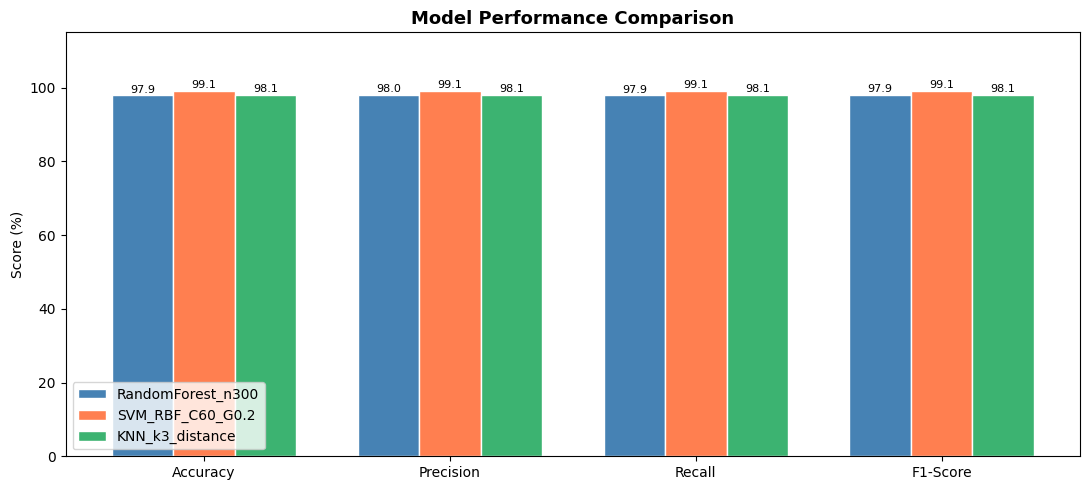


=== Overfit Check ===
Model                 Train Acc   Test Acc      Gap
----------------------------------------------------
RandomForest_n300        99.99%     97.94%    2.05%
SVM_RBF_C60_G0.2         99.56%     99.08%    0.47%
KNN_k3_distance         100.00%     98.11%    1.89%


In [41]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model_names = list(results_full.keys())
x = np.arange(len(metrics))
width = 0.25
colors = ['steelblue', 'coral', 'mediumseagreen']

fig, ax = plt.subplots(figsize=(11, 5))
for idx, (name, color) in enumerate(zip(model_names, colors)):
    r = results_full[name]
    vals = [
        r['test_acc'],
        r['precision_weighted'],
        r['recall_weighted'],
        r['f1_weighted']
    ]
    bars = ax.bar(x + idx * width, [v * 100 for v in vals],
                  width, label=name, color=color, edgecolor='white')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
                f'{val*100:.1f}', ha='center', va='bottom', fontsize=8)

ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 115)
ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.set_ylabel('Score (%)')
ax.legend()
plt.tight_layout()
plt.show()

# Overfit summary table
print('\n=== Overfit Check ===')
print(f'{"Model":<20} {"Train Acc":>10} {"Test Acc":>10} {"Gap":>8}')
print('-' * 52)
for name, r in results_full.items():
    gap = r['train_acc'] - r['test_acc']
    print(f'{name:<20} {r["train_acc"]*100:>9.2f}% {r["test_acc"]*100:>9.2f}% {gap*100:>7.2f}%')


## 13. Confusion Matrix for Best Model

Identify the **best-performing model** (highest test accuracy → SVM).

Generate and display a **heatmap confusion matrix** showing predicted vs actual gesture labels for the test set.

This reveals which gestures, if any, the model confuses with one another.


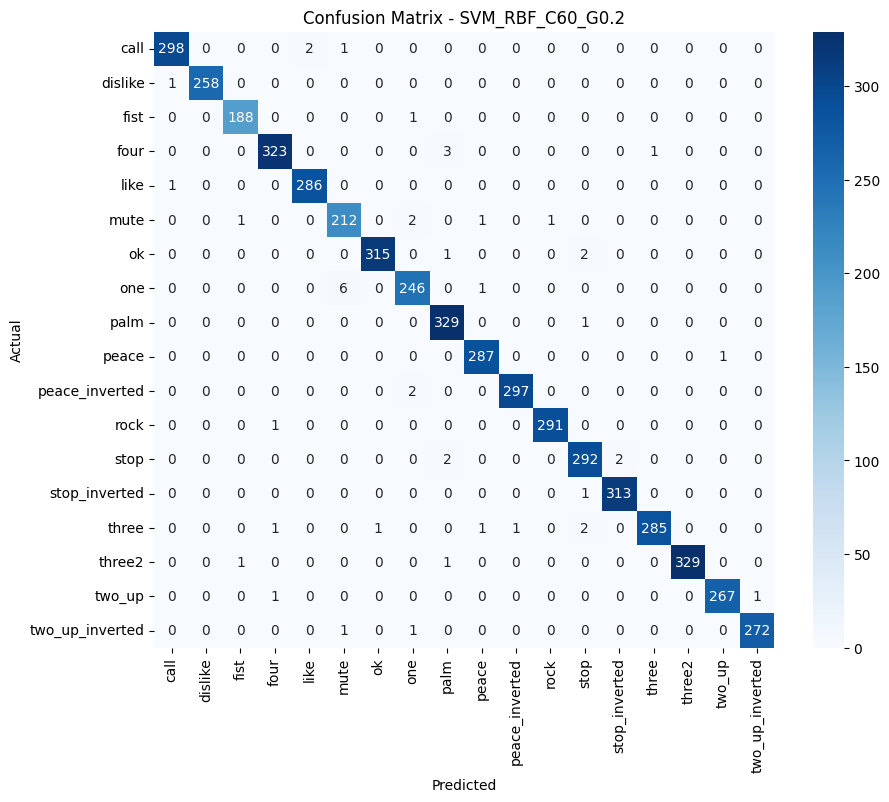

Best Model: SVM_RBF_C60_G0.2


In [42]:
# Select best model by test accuracy
best_model_name = max(results_full, key=lambda k: results_full[k]['test_acc'])
best_model = models[best_model_name]

# Make predictions
preds = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

print("Best Model:", best_model_name)

## 14. Save Best Model

Serialize the best model and label encoder to disk using **joblib**:
- `best_gesture_model.pkl` — trained SVM classifier  
- `label_encoder.pkl` — fitted `LabelEncoder` to decode predictions back to gesture names


In [44]:
best_run_id = "0e72d5964a54465bbc1f71d22fa54b83"

register_model(
    f"runs:/{best_run_id}/model",
    "HandGesture_Production_Model"
)

Successfully registered model 'HandGesture_Production_Model'.
2026/02/28 23:22:50 WARNING mlflow.tracking._model_registry.fluent: Run with id 0e72d5964a54465bbc1f71d22fa54b83 has no artifacts at artifact path 'model', registering model based on models:/m-b8a9a0970189446280d8432fc3994e9f instead
2026/02/28 23:22:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HandGesture_Production_Model, version 1
Created version '1' of model 'HandGesture_Production_Model'.


In [43]:
joblib.dump(best_model, "best_gesture_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("Model saved successfully.")

Model saved successfully.


---

## Part 2: Real-Time Inference

The cells below implement **live webcam-based gesture recognition** using the saved model and MediaPipe hand tracking.


## 15. Real-Time Imports

Import additional libraries needed for real-time inference:
- **cv2 (OpenCV)** — webcam capture and frame display  
- **mediapipe** — real-time hand landmark detection  
- **deque / Counter** — sliding window buffer for stable predictions  


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from collections import deque, Counter
import joblib

## 16. Load Saved Model & Encoder

Reload the best model and label encoder from disk for inference.


In [ ]:
best_model = joblib.load("best_gesture_model.pkl")
le = joblib.load("label_encoder.pkl")

## 17. Load Training Feature Columns

Reload the training CSV to extract the **exact feature column order**.  
This ensures the live inference DataFrame matches the feature layout the model was trained on.


In [ ]:
import pandas as pd

# Load the CSV used for training
train_df = pd.read_csv('/Users/ahmedtarek/Developer/Python/ML1 Project/hand_landmarks_data.csv')

trained_feature_columns = [col for col in train_df.columns if col != 'label']

In [ ]:
# MediaPipe setup
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)

window_size = 20
prediction_buffer = deque(maxlen=window_size)

def normalize_landmarks(hand_landmarks):
    coords = np.array([[lm.x, lm.y, lm.z]
                       for lm in hand_landmarks.landmark], dtype=np.float32)

    # 1️⃣ Translation (X and Y only)
    wrist = coords[0].copy()
    coords[:, 0] -= wrist[0]  # X
    coords[:, 1] -= wrist[1]  # Y

    # 2️⃣ Scale using 4 fingertips (no thumb), 2D only
    fingertip_indices = [8, 12, 16, 20]
    fingertip_distances = np.linalg.norm(coords[fingertip_indices][:, :2], axis=1)
    scale = np.mean(fingertip_distances)

    if scale < 1e-6:
        scale = 1e-6

    coords[:, 0] /= scale  # X
    coords[:, 1] /= scale  # Y

    return coords.flatten() 

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError('Cannot open camera')

try:
    while True:
        success, frame = cap.read()
        if not success:
            break

        frame = cv2.flip(frame, 1)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb)

        display_text = 'No hand'

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            mp_draw.draw_landmarks(
                frame, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS
            )

            landmarks = normalize_landmarks(hand_landmarks)
            landmarks_df = pd.DataFrame([landmarks], columns=trained_feature_columns)
            encoded_pred = best_model.predict(landmarks_df)[0]
            gesture_name = le.inverse_transform([encoded_pred])[0]

            prediction_buffer.append(gesture_name)

            if len(prediction_buffer) == window_size:
                display_text = Counter(prediction_buffer).most_common(1)[0][0]
            else:
                display_text = "Stabilizing..."

        else:
            prediction_buffer.clear()

        cv2.putText(
            frame, 
            display_text, 
            (10, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (0, 255, 0), 
            2
        )

        cv2.imshow("Hand Gesture Recognition", frame)

        if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to quit
            break
        
except KeyboardInterrupt:
    print('Stopped.')

finally:
    cap.release()
    hands.close()
    cv2.destroyAllWindows()
    for _ in range(5):
        cv2.waitKey(1)
        
    print('Camera released.')

I0000 00:00:1772146098.294177       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro


Camera released.
